In [2]:
import numpy as np
import pandas as pd
import math

from scipy.optimize import minimize, Bounds, fmin_cg
from skopt import gp_minimize
from deap import base, creator, tools, algorithms
import random
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

from matplotlib import pyplot as plt
import seaborn as sns

import yfinance as yf
import pandas_datareader as pdr
import pandas_market_calendars as mcal

import datetime

In [3]:
end_date = datetime.date.today()
start_date = end_date - datetime.timedelta(days=360*3)
nyse = mcal.get_calendar('NYSE')
valid_dates = nyse.valid_days(start_date=start_date, end_date =end_date)
valid_start_day = valid_dates[0].date()
valid_end_day = valid_dates[-1].date()

#S&P 500 ticker
SnP_componet_ticker = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0].Symbol

def final_ticker(T_list):
    return list(set(T_list))

index_banch_mart = ["^GSPC"]

tickers = final_ticker(SnP_componet_ticker)

def get_stock_data(tickers_list, start_date, end_date=None):
    
    all_tickers = list(dict.fromkeys(tickers_list))
    
    data = yf.download(all_tickers, start=start_date, end=end_date)['Close']
    if isinstance(data, pd.DataFrame):
        data = data.dropna(axis=1)
        available_tickers = list(data.columns)
    else:
        available_tickers = all_tickers
    
    return data, available_tickers

def initialize_portfolio(tickers, equal_weight=True):
    n_assets = len(tickers)
    if equal_weight:
        weight = 1.0/n_assets
    else:
        weight = 1.0
        
    return {ticker: weight for ticker in tickers}

df,tickers = get_stock_data(tickers,valid_start_day)

df_BM,_ = get_stock_data(index_banch_mart, valid_start_day)
number_of_stocks = df.shape[1]

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  503 of 503 completed

2 Failed downloads:
['BF.B']: YFPricesMissingError('possibly delisted; no price data found  (1d 2022-04-26 -> 2025-04-10)')
['BRK.B']: YFTzMissingError('possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed


In [4]:
def Get_rfr(start):
    risk_free_rate = pd.DataFrame()
    shifted_date = 0 # change this if you run this on a non-trading day, just in case
    while risk_free_rate.empty:
        risk_free_rate = pdr.DataReader('DGS3MO', 'fred', start).dropna()
        shifted_date += 1
    return risk_free_rate/100
rfr = Get_rfr(valid_start_day)

In [5]:
SnP_sector_ETF_tickers = [
    "XLC",  # Communication Services
    "XLY",  # Consumer Discretionary
    "XLP",  # Consumer Staples
    "XLE",  # Energy
    "XLF",  # Financials
    "XLV",  # Health Care
    "XLI",  # Industrials
    "XLK",  # Technology
    "XLB",  # Materials
    "XLRE", # Real Estate
    "XLU"   # Utilities
]
SnP_ETF_ticker = ['VOO']
SnP_sector_ETF_tickers = final_ticker(SnP_sector_ETF_tickers+SnP_ETF_ticker)

df_sector_etfs,tickers_ETFs = get_stock_data(SnP_sector_ETF_tickers,valid_start_day)

[*********************100%***********************]  12 of 12 completed


## Previous strategy

Decompose SnP500 into principle componet, then pick the top 5 component that has the highest sharp ratio, hold for a month.

## New strategy
1) Decompose SnP500 into principle componet
2) Pick the top 5 principle components with highest sharp ratio
3) Do linear regression for the PCs and the SnP sector ETF, re-map everything into these ETF(Lower borrowing cost, management cost, etc)
4) Update every month, past window = 252 days, holding period = 21 days

In [8]:
def calculate_returns(df, df_sector_etfs, rfr):
    """Calculate both log returns (for PCA) and simple returns (for performance)"""
    # Log returns for PCA
    log_ret_df = np.log(df/df.shift(1)).dropna()
    log_ret_sector = np.log(df_sector_etfs/df_sector_etfs.shift(1)).dropna()
    
    # Simple returns for performance calculation
    simple_ret_df = df.pct_change().dropna()
    simple_ret_sector = df_sector_etfs.pct_change().dropna()
    
    rfr_aligned = rfr.reindex(log_ret_df.index, method='ffill')
    
    return log_ret_df, log_ret_sector, simple_ret_df, simple_ret_sector, rfr_aligned

def calculate_pc_performance(window_data, loadings, window_rfr):
    """Calculate performance metrics and Sharpe ratio for each PC"""
    pc_performance = pd.DataFrame(index=loadings.columns)
    
    for pc in loadings.columns:
        pc_returns = (window_data @ loadings[pc])
        simple_returns = np.exp(pc_returns) - 1
        annual_return = (1 + simple_returns.mean()) ** 252 - 1
        annual_vol = simple_returns.std() * np.sqrt(252)
        window_annual_rfr = window_rfr * 252

        # Add check for zero volatility
        if annual_vol == 0:
            pc_performance.loc[pc, 'Sharpe'] = 0
        else:
            pc_performance.loc[pc, 'Sharpe'] = (annual_return - window_annual_rfr) / annual_vol
    
    return pc_performance

def calculate_performance_metrics(returns, rfr):
    """Calculate performance metrics for a strategy"""
    # Handle different input types
    if isinstance(returns, (float, np.float64)):
        return {
            'returns': 0,
            'cum_returns': 1,
            'annual_return': 0,
            'annual_vol': 0,
            'sharpe': 0
        }
    
    # Convert to pandas Series if it's numpy array
    if isinstance(returns, np.ndarray):
        returns = pd.Series(returns)
    
    # Calculate simple returns from log returns
    try:
        simple_returns = pd.Series(np.exp(returns.values) - 1, index=returns.index)
    except:
        simple_returns = pd.Series(returns.values, index=returns.index)
    
    cum_returns = (1 + simple_returns).cumprod()
    
    # Calculate annualized metrics
    annual_return = (1 + simple_returns.mean()) ** 252 - 1
    annual_vol = simple_returns.std() * np.sqrt(252)
    
    # Handle zero volatility case
    if annual_vol == 0 or np.isnan(annual_vol):
        sharpe = 0
    else:
        sharpe = (annual_return - rfr) / annual_vol
    
    return {
        'returns': simple_returns,
        'cum_returns': cum_returns,
        'annual_return': annual_return,
        'annual_vol': annual_vol,
        'sharpe': sharpe
    }

def calculate_performance_metrics_simple(returns, rfr):
    """Calculate performance metrics for a strategy using simple returns"""
    if isinstance(returns, (float, np.float64)):
        return {
            'returns': 0,
            'cum_returns': 1,
            'annual_return': 0,
            'annual_vol': 0,
            'sharpe': 0
        }
    
    # Convert to pandas Series if it's numpy array
    if isinstance(returns, np.ndarray):
        returns = pd.Series(returns)
    
    cum_returns = (1 + returns).cumprod()
    
    # Calculate annualized metrics
    annual_return = (1 + returns.mean()) ** 252 - 1
    annual_vol = returns.std() * np.sqrt(252)
    
    # Handle zero volatility case
    if annual_vol == 0 or np.isnan(annual_vol):
        sharpe = 0
    else:
        sharpe = (annual_return - rfr) / annual_vol
    
    return {
        'returns': returns,
        'cum_returns': cum_returns,
        'annual_return': annual_return,
        'annual_vol': annual_vol,
        'sharpe': sharpe
    }

def perform_pca_analysis(data, n_components):
    """Perform PCA analysis on the data"""
    # Standardize the data
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)
    
    # Perform PCA
    pca = PCA(n_components=n_components)
    pca_results = pd.DataFrame(
        pca.fit_transform(data_scaled),
        index=data.index,
        columns=[f'PC{i+1}' for i in range(n_components)]
    )
    
    # Get loadings
    loadings = pd.DataFrame(
        pca.components_.T,
        columns=pca_results.columns,
        index=data.columns
    )
    
    return pca_results, loadings

def calculate_sector_betas(pc_returns, sector_returns):
    """Calculate betas for each PC against sector ETFs using linear regression"""
    betas = pd.DataFrame(index=sector_returns.columns, columns=pc_returns.columns)
    
    # Standardize PC returns to prevent numerical issues
    pc_returns_std = pc_returns.apply(lambda x: (x - x.mean()) / x.std())
    sector_returns_std = sector_returns.apply(lambda x: (x - x.mean()) / x.std())
    
    for pc in pc_returns.columns:
        for sector in sector_returns.columns:
            try:
                model = LinearRegression()
                X = pc_returns_std[pc].values.reshape(-1, 1)
                y = sector_returns_std[sector].values
                model.fit(X, y)
                betas.loc[sector, pc] = model.coef_[0]
            except:
                betas.loc[sector, pc] = 0
                
    # Clip extreme values
    betas = betas.clip(-1, 1)
    
    return betas

def construct_portfolio(loadings, top_pcs, sector_betas):
    """Construct final portfolio using PC loadings and sector betas"""
    # First construct stock weights from PCs
    stock_weights = pd.Series(0.0, index=loadings.index)
    for pc in top_pcs:
        stock_weights += loadings[pc] / len(top_pcs)
    
    # Normalize stock weights
    if stock_weights.sum() != 0:
        stock_weights = stock_weights / stock_weights.sum()
    
    # Calculate sector weights as mean of standardized betas
    sector_weights = sector_betas[top_pcs].mean(axis=1)
    
    # Ensure weights sum to 1 and are reasonable
    if sector_weights.sum() != 0:
        sector_weights = sector_weights / abs(sector_weights.sum())
    
    return stock_weights, sector_weights

def plot_strategy_results(results):
    """Plot both strategy results along with benchmark"""
    fig, ax = plt.subplots(figsize=(15, 8))
    
    pc_perf = results['pc_performance']
    etf_perf = results['etf_performance']
    bm_perf = results['benchmark_performance']
    
    ax.plot(pc_perf['cum_returns'].index, pc_perf['cum_returns'], 
            label=f'PC basis (Sharpe: {pc_perf["sharpe"]:.2f})')
    ax.plot(etf_perf['cum_returns'].index, etf_perf['cum_returns'], 
            label=f'ETF basis (Sharpe: {etf_perf["sharpe"]:.2f})')
    ax.plot(bm_perf['cum_returns'].index, bm_perf['cum_returns'], 
            label=f'S&P 500 (Sharpe: {bm_perf["sharpe"]:.2f})', linestyle='--')
    
    ax.set_title('PCA Strategy Performance')
    ax.set_xlabel('Date')
    ax.set_ylabel('Cumulative Return')
    ax.legend()
    ax.grid(True)
    
    plt.tight_layout()
    return fig, ax

def Market_metric(result):
    
    import Functions.AlphaBeta as MT
    
    pc_rt = results['pc_strategy_returns']
    etf_rt = results['etf_strategy_returns']
    bm_rt = results['benchmark_returns']
    
    fig, ax = plt.subplots(figsize=(15, 8))
    plt.title('PCA')
    PC_alpha, PC_beta = MT.AlphaBeta(bm_rt,pc_rt,plot=True)
    print(f'PCA: Alpha = {PC_alpha}, Beta = {PC_beta}')
    PCA_Down_metric = MT.downside_metrics(pc_rt, bm_rt)
    print('PCA drawdown metric')
    for k in PCA_Down_metric:
        print(f'{k}: {PCA_Down_metric[k]}')

    fig, ax = plt.subplots(figsize=(15, 8))
    alpha, beta = MT.AlphaBeta(bm_rt,etf_rt,plot=True)
    print(f'ETFs: Alpha = {alpha}, Beta = {beta}')
    ETF_Down_metric = MT.downside_metrics(etf_rt, bm_rt)
    print('ETF drawdown metric')
    for k in ETF_Down_metric:
        print(f'{k}: {ETF_Down_metric[k]}')
    return alpha, beta


In [9]:
def rolling_pca_strategy(df, df_sector_etfs, rfr, df_BM, lookback_days=252, holding_days=5, n_components=5):
    """Main strategy function"""
    # Initialize and align all data
    log_ret_df, log_ret_sector, simple_ret_df, simple_ret_sector, rfr_aligned = calculate_returns(df, df_sector_etfs, rfr)
    
    # Convert benchmark to Series if it's a DataFrame
    if isinstance(df_BM, pd.DataFrame):
        df_BM = df_BM.iloc[:, 0]
    
    # Calculate benchmark returns
    ret_BM = df_BM.pct_change().dropna()
    
    # Initialize return series
    strategy_returns_pc = pd.Series(index=simple_ret_df.index, dtype=float)     # Direct PC strategy
    strategy_returns_etf = pd.Series(index=simple_ret_df.index, dtype=float)    # ETF-mapped strategy
    selected_pcs_history = []
    
    # Get all dates
    all_dates = simple_ret_df.index.tolist()
    current_idx = 0
    
    while current_idx < len(all_dates):
        start_date = all_dates[current_idx]
        
        # Define the window
        lookback_start_idx = max(0, current_idx - lookback_days)
        window_data_log = log_ret_df.iloc[lookback_start_idx:current_idx]
        window_sector_log = log_ret_sector.iloc[lookback_start_idx:current_idx]
        
        if len(window_data_log) < 30:
            current_idx += holding_days
            continue
        
        window_rfr = rfr_aligned.loc[window_data_log.index].mean()
        if isinstance(window_rfr, pd.Series):
            window_rfr = window_rfr.iloc[0]
        window_rfr = window_rfr / 252
        
        # Perform PCA on log returns
        pca_results, loadings = perform_pca_analysis(window_data_log, n_components)
        
        # Calculate PC performance and select top PCs
        pc_performance = calculate_pc_performance(window_data_log, loadings, window_rfr)
        top_pcs = pc_performance.nlargest(n_components, 'Sharpe').index
        selected_pcs_history.append((start_date, top_pcs))
        
        # Calculate sector betas using log returns
        sector_betas = calculate_sector_betas(pca_results[top_pcs], window_sector_log)
        
        # Define holding period
        hold_end_idx = min(current_idx + holding_days, len(all_dates))
        hold_dates = all_dates[current_idx:hold_end_idx]
        
        if len(hold_dates) == 0:
            break
        
        # Calculate portfolio returns using simple returns
        holding_window = simple_ret_df.loc[hold_dates]
        sector_holding_window = simple_ret_sector.loc[hold_dates]
        
        # Strategy 1: Direct PC portfolio
        pc_weights = pd.Series(0.0, index=loadings.index)
        for pc in top_pcs:
            pc_weights += loadings[pc] / len(top_pcs)
        if pc_weights.sum() != 0:
            pc_weights = pc_weights / pc_weights.sum()
        
        # Strategy 2: ETF-mapped portfolio
        sector_weights = sector_betas[top_pcs].mean(axis=1)
        if sector_weights.sum() != 0:
            sector_weights = sector_weights / abs(sector_weights.sum())
        
        # Calculate returns for both strategies using simple returns
        pc_portfolio_returns = (holding_window * pc_weights).sum(axis=1)
        etf_portfolio_returns = (sector_holding_window * sector_weights).sum(axis=1)
        
        # Assign values
        strategy_returns_pc.loc[hold_dates] = pc_portfolio_returns.astype(float)
        strategy_returns_etf.loc[hold_dates] = etf_portfolio_returns.astype(float)
        
        current_idx += holding_days
    
    # Drop NaN values and align all return series
    strategy_returns_pc = strategy_returns_pc.dropna()
    strategy_returns_etf = strategy_returns_etf.dropna()
    
    # Align all return series
    common_dates = strategy_returns_pc.index.intersection(
        strategy_returns_etf.index.intersection(ret_BM.index)
    )
    
    strategy_returns_pc = strategy_returns_pc.loc[common_dates]
    strategy_returns_etf = strategy_returns_etf.loc[common_dates]
    ret_BM = ret_BM.loc[common_dates]
    
    # Calculate performance metrics
    final_rfr = rfr_aligned.loc[common_dates].mean()
    if isinstance(final_rfr, pd.Series):
        final_rfr = final_rfr.iloc[0]
    
    pc_performance = calculate_performance_metrics_simple(strategy_returns_pc, final_rfr)
    etf_performance = calculate_performance_metrics_simple(strategy_returns_etf, final_rfr)
    bm_performance = calculate_performance_metrics_simple(ret_BM, final_rfr)
    
    return {
        'pc_strategy_returns': strategy_returns_pc,
        'etf_strategy_returns': strategy_returns_etf,
        'benchmark_returns': ret_BM,
        'selected_pcs_history': selected_pcs_history,
        'pc_performance': pc_performance,
        'etf_performance': etf_performance,
        'benchmark_performance': bm_performance
    }

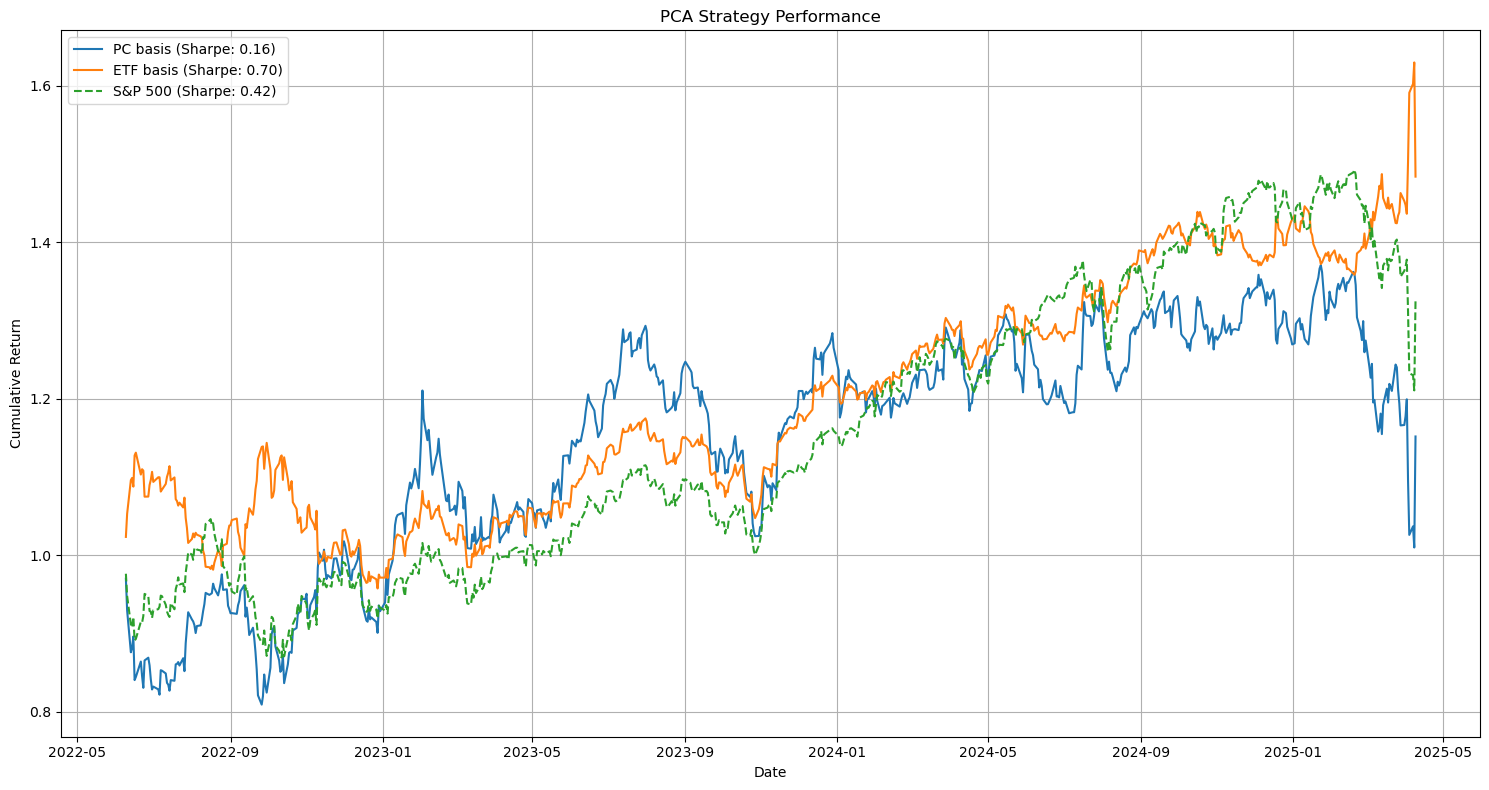

In [10]:
results = rolling_pca_strategy(df, df_sector_etfs, rfr,df_BM)
fig, ax = plot_strategy_results(results)
plt.show()

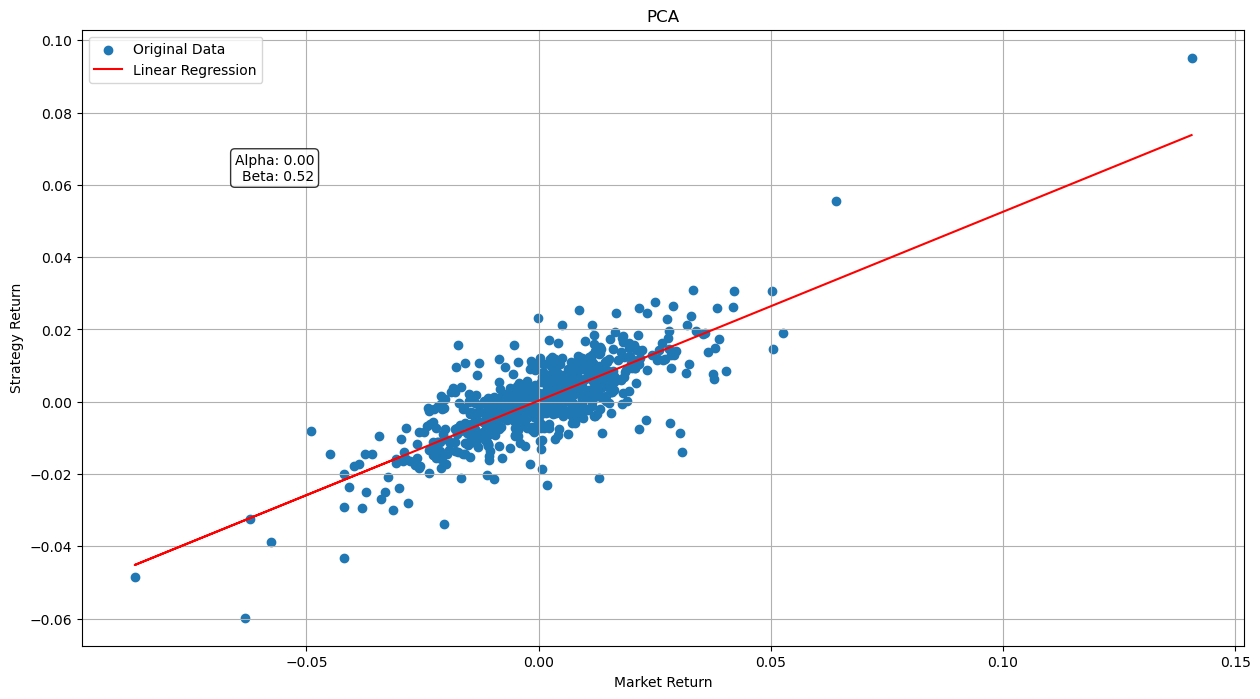

PCA: Alpha = 0.0, Beta = 0.523
PCA drawdown metric
max_drawdown: -0.26338179596686834
max_drawdown_duration: 197
var_95: -0.02566566755316621
cvar_95: -0.03734920048800103
down_beta: 1.2172640925786211


/Users/arnold/Coding/Portfolio_theory/Functions/AlphaBeta.py:76: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if drawdowns[i] < 0:
/Users/arnold/Coding/Portfolio_theory/Functions/AlphaBeta.py:80: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if drawdowns[i] == 0:


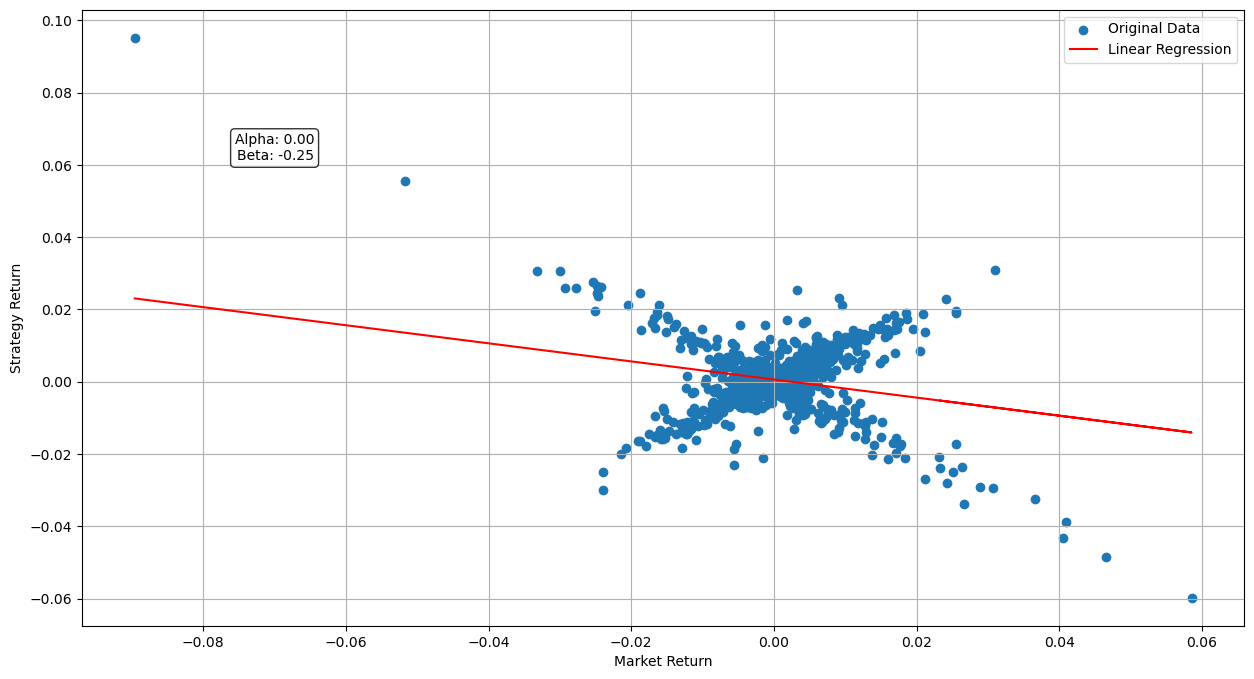

ETFs: Alpha = 0.001, Beta = -0.25
ETF drawdown metric
max_drawdown: -0.16281876810299722
max_drawdown_duration: 193
var_95: -0.015648450524340166
cvar_95: -0.023448522890203025
down_beta: -0.5729261240080854


In [11]:
ETF_alpha, ETF_beta = Market_metric(results)

## Hedging strategy

Instead of hedge with SnP ETF, we will hedge with SnP 500 future, as it allow one to entre short position while advoiding floating borrowing cost.

Adjusting the beta: 
The beta was
$$
\beta_\mathrm{strategy} = \frac{Cov(R_\mathrm{strategy}, R_\mathrm{benchmark})}{Var(R_\mathrm{benchmark})}
$$
and the fair futrue price is
$$
F_t = S_t e^{(r-d)(T-t)},
$$
thus the adjusted beta would be:
$$
\beta_\mathrm{futures} = \frac{\beta_\mathrm{strategy}}{e^{(r-d)(T-t)}}
$$

The hedged portfolio would become
$$
\mathrm{Portfolio}_t = \mathrm{Strategy}_t - \beta_\mathrm{futures} \times \mathrm{Futures}_t
$$



In [13]:
def rolling_pca_strategy_with_hedge(df, df_sector_etfs, rfr, df_BM, futures_data, 
                                  lookback_days=252, holding_days=5, n_components=5, 
                                  beta_window=63):
    """Main strategy function with futures hedging"""
    # Initialize and align all data
    log_ret_df, log_ret_sector, simple_ret_df, simple_ret_sector, rfr_aligned = calculate_returns(df, df_sector_etfs, rfr)
    
    # Calculate returns and ensure they're Series
    ret_BM = df_BM.pct_change().dropna()
    if isinstance(futures_data, pd.DataFrame):
        futures_returns = futures_data.iloc[:, 0].pct_change().dropna()
    else:
        futures_returns = futures_data.pct_change().dropna()
    
    # Initialize return series
    strategy_returns_pc = pd.Series(index=simple_ret_df.index, dtype=float)
    strategy_returns_etf = pd.Series(index=simple_ret_df.index, dtype=float)
    hedged_returns = pd.Series(index=simple_ret_df.index, dtype=float)
    rolling_betas = pd.Series(index=simple_ret_df.index, dtype=float)
    selected_pcs_history = []
    
    # Store strategy returns for beta calculation
    strategy_returns_history = pd.Series(dtype=float, index=simple_ret_df.index)
    
    # Get all dates
    all_dates = simple_ret_df.index.tolist()
    current_idx = 0
    
    while current_idx < len(all_dates):
        current_date = all_dates[current_idx]
        
        # Define the window for strategy
        lookback_start_idx = max(0, current_idx - lookback_days)
        window_data_log = log_ret_df.iloc[lookback_start_idx:current_idx]
        window_sector_log = log_ret_sector.iloc[lookback_start_idx:current_idx]
        
        if len(window_data_log) < 30:
            current_idx += holding_days
            continue
            
        # Calculate beta using the rolling window
        if current_idx >= beta_window:
            beta_start_idx = current_idx - beta_window
            beta_dates = all_dates[beta_start_idx:current_idx]
            
            # Get strategy and futures returns for beta window
            strat_returns = strategy_returns_history[beta_dates].dropna()
            fut_returns = futures_returns.loc[beta_dates].dropna()
            
            # Align the returns
            common_dates = strat_returns.index.intersection(fut_returns.index)
            if len(common_dates) >= 30:
                strat_returns = strat_returns.loc[common_dates]
                fut_returns = fut_returns.loc[common_dates]
                
                try:
                    # Use custom AlphaBeta function
                    import Functions.AlphaBeta as MT
                    alpha, beta = MT.AlphaBeta(fut_returns, strat_returns, plot=False)
                    rolling_betas.loc[current_date] = beta
                except Exception as e:
                    print(f"Beta calculation failed for {current_date}: {str(e)}")
                    continue
        
        # Rest of strategy calculation
        window_rfr = rfr_aligned.loc[window_data_log.index].mean()
        if isinstance(window_rfr, pd.Series):
            window_rfr = window_rfr.iloc[0]
        window_rfr = window_rfr / 252
        
        pca_results, loadings = perform_pca_analysis(window_data_log, n_components)
        pc_performance = calculate_pc_performance(window_data_log, loadings, window_rfr)
        top_pcs = pc_performance.nlargest(n_components, 'Sharpe').index
        selected_pcs_history.append((current_date, top_pcs))
        
        sector_betas = calculate_sector_betas(pca_results[top_pcs], window_sector_log)
        
        pc_weights = pd.Series(0.0, index=loadings.index)
        for pc in top_pcs:
            pc_weights += loadings[pc] / len(top_pcs)
        if pc_weights.sum() != 0:
            pc_weights = pc_weights / pc_weights.sum()
        
        sector_weights = sector_betas[top_pcs].mean(axis=1)
        if sector_weights.sum() != 0:
            sector_weights = sector_weights / abs(sector_weights.sum())
        
        hold_end_idx = min(current_idx + holding_days, len(all_dates))
        hold_dates = all_dates[current_idx:hold_end_idx]
        
        if len(hold_dates) == 0:
            break
            
        holding_window = simple_ret_df.loc[hold_dates]
        sector_holding_window = simple_ret_sector.loc[hold_dates]
        
        pc_portfolio_returns = (holding_window * pc_weights).sum(axis=1)
        etf_portfolio_returns = (sector_holding_window * sector_weights).sum(axis=1)
        
        # Store returns and apply hedging
        for hold_date in hold_dates:
            strategy_returns_pc.loc[hold_date] = pc_portfolio_returns.loc[hold_date]
            strategy_returns_etf.loc[hold_date] = etf_portfolio_returns.loc[hold_date]
            strategy_returns_history.loc[hold_date] = etf_portfolio_returns.loc[hold_date]
            
            if hold_date in rolling_betas.index and not np.isnan(rolling_betas[hold_date]):
                beta = rolling_betas[hold_date]
                if hold_date in futures_returns.index:
                    hedge_return = -beta * futures_returns.loc[hold_date]
                    hedged_returns.loc[hold_date] = etf_portfolio_returns.loc[hold_date] + hedge_return
                else:
                    hedged_returns.loc[hold_date] = etf_portfolio_returns.loc[hold_date]
            else:
                hedged_returns.loc[hold_date] = etf_portfolio_returns.loc[hold_date]
        
        current_idx += holding_days
    
    # Align all return series
    hedged_returns.dropna(inplace=True)
    common_dates = strategy_returns_etf.index.intersection(hedged_returns.index.intersection(ret_BM.index))
    
    return {
        'pc_strategy_returns': strategy_returns_pc.loc[common_dates],
        'etf_strategy_returns': strategy_returns_etf.loc[common_dates],
        'hedged_returns': hedged_returns.loc[common_dates],
        'benchmark_returns': ret_BM.loc[common_dates],
        'selected_pcs_history': selected_pcs_history,
        'rolling_betas': rolling_betas.loc[common_dates]
    }

In [14]:
SnP_futures = yf.download("ES=F", start=valid_start_day)['Close']

[*********************100%***********************]  1 of 1 completed


In [15]:
Hedged_result = rolling_pca_strategy_with_hedge(df, df_sector_etfs, rfr,df_BM, SnP_futures)

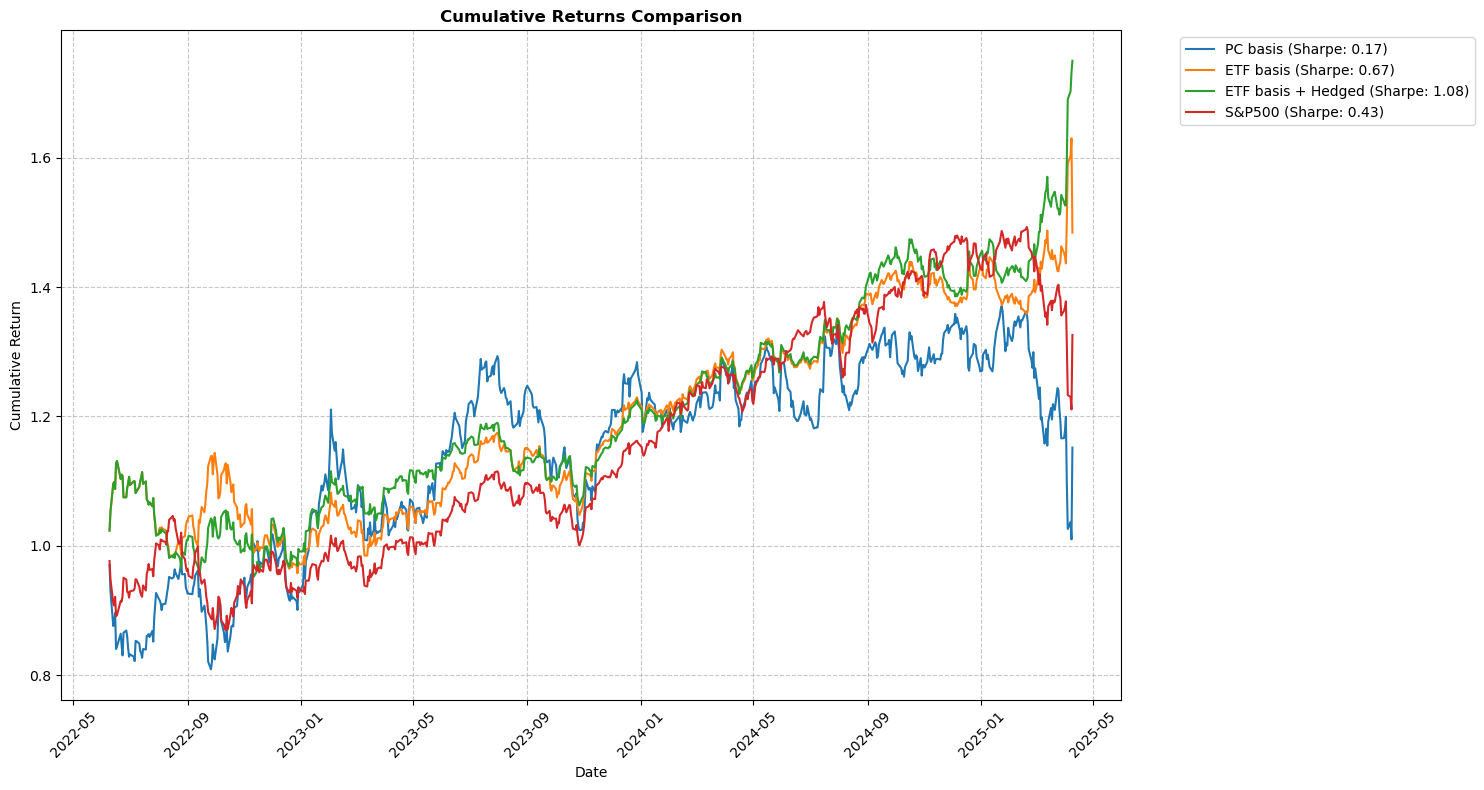

Strategy PC sharpe ratio: 937.6642306243468


In [86]:
def plot_cumulative_returns(strategy_results, rfr=0.04):
    # Calculate cumulative returns
    cum_pc_strategy = (1 + strategy_results['pc_strategy_returns']).cumprod()
    cum_etf_strategy = (1 + strategy_results['etf_strategy_returns']).cumprod()
    cum_hedged = (1 + strategy_results['hedged_returns']).cumprod()
    cum_benchmark = (1 + strategy_results['benchmark_returns']).cumprod()
    
    # Calculate Sharpe ratios
    def calculate_sharpe(returns, rfr=rfr):
        annual_return = returns.mean() * 252
        annual_vol = returns.std() * np.sqrt(252)
        sharpe = (annual_return - rfr) / annual_vol
        # Convert Series to scalar if needed
        if hasattr(sharpe, 'iloc'):
            sharpe = sharpe.iloc[0]
        return sharpe
    
    sharpe_pc = calculate_sharpe(strategy_results['pc_strategy_returns'])
    sharpe_etf = calculate_sharpe(strategy_results['etf_strategy_returns'])
    sharpe_hedged = calculate_sharpe(strategy_results['hedged_returns'])
    sharpe_benchmark = calculate_sharpe(strategy_results['benchmark_returns'])
    
    # Create the plot
    plt.figure(figsize=(15, 8))
    plt.plot(cum_pc_strategy, label=f'PC basis (Sharpe: {sharpe_pc:.2f})', linewidth=1.5)
    plt.plot(cum_etf_strategy, label=f'ETF basis (Sharpe: {sharpe_etf:.2f})', linewidth=1.5)
    plt.plot(cum_hedged, label=f'ETF basis + Hedged (Sharpe: {sharpe_hedged:.2f})', linewidth=1.5)
    plt.plot(cum_benchmark, label=f'S&P500 (Sharpe: {sharpe_benchmark:.2f})', linewidth=1.5)

    # Customize the plot
    plt.title('Cumulative Returns Comparison', fontsize=12, fontweight='bold')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)

    # Adjust layout to prevent label cutoff
    plt.tight_layout()

    plt.show()
    
    # Still print the Sharpe for PC strategy for backward compatibility
    Sharpe_performance((1 + strategy_results['pc_strategy_returns']), 'PC', rfr)


def Sharpe_performance(strategy, tage, rfr=0.04):
    An_mean_re = strategy.mean()*252
    An_vol = strategy.std()*np.sqrt(252)
    sharpe = (An_mean_re-rfr)/An_vol
    # Convert Series to scalar if needed
    if hasattr(sharpe, 'iloc'):
        sharpe = sharpe.iloc[0]
    print(f'Strategy {tage} sharpe ratio: {sharpe}')


# Usage:
plot_cumulative_returns(Hedged_result)

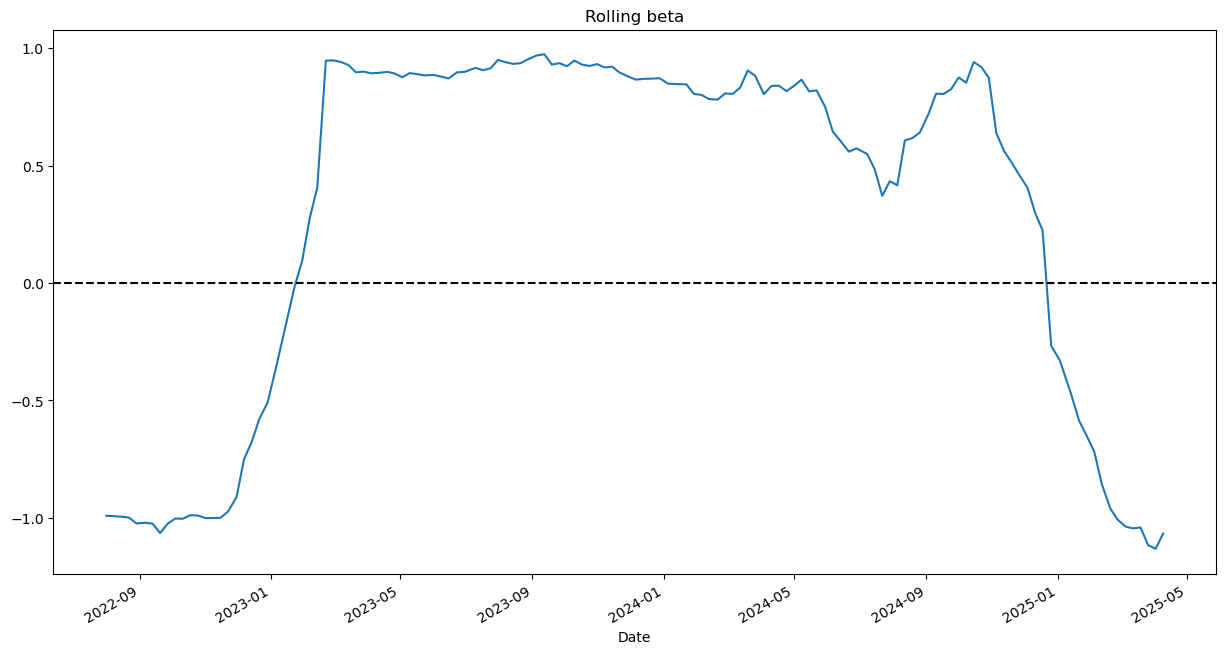

In [88]:
Hedged_result['rolling_betas'].dropna().plot(figsize=(15, 8),title='Rolling beta')
plt.axhline(y=0,linestyle='--',color='black')
plt.show()